In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
from collections import OrderedDict


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch_norm(x)
        x = F.relu(self.conv2(x))
        x = self.batch_norm(x)
        return x

class DeConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DeConvBlock, self).__init__()
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.deconv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.deconv1(x))
        x = self.batch_norm(x)
        x = F.relu(self.deconv2(x))
        x = self.batch_norm(x)
        return x
    
class trans_block(nn.Module):
    def __init__(self, inplanes, outplanes):
        super(trans_block, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, inplanes, kernel_size =1, stride=1)
        self.bn1 = nn.BatchNorm2d(inplanes)        
        self.conv2 = nn.ConvTranspose2d(inplanes, inplanes, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(inplanes)
        self.conv3 = nn.Conv2d(inplanes, outplanes, kernel_size =1, stride=1)
        self.bn3 = nn.BatchNorm2d(outplanes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)
        return out
    
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.encoder_1 = ConvBlock(3,64)
        self.encoder_2 = ConvBlock(64,128)
        self.encoder_3 = ConvBlock(128,256)
        self.encoder_4 = ConvBlock(256,512)
        
        self.center = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )  
        
        self.decoder_1 = DeConvBlock(1536,512)
        self.decoder_2 = DeConvBlock(768,256)
        self.decoder_3 = DeConvBlock(384,128)
        self.decoder_4 = DeConvBlock(192,64)
        
        self.final = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, padding=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )  

        self.maxpool = nn.MaxPool2d((2, 2), stride=(2, 2), return_indices=True)       

        self.up1 = trans_block(1024,1024)
        self.up2 = trans_block(512,512)
        self.up3 = trans_block(256,256)
        self.up4 = trans_block(128,128)

        self.unpool = nn.MaxUnpool2d(2, stride=2)  # get masks
        
        
        #self.classifier = nn.Softmax()

    def forward(self, x):       
        
        size_1 = x.size()
        enc1 = self.encoder_1(x)
        x,indices1 = self.maxpool(enc1) 
        
        size_2 = x.size()
        enc2 = self.encoder_2(x)
        x,indices2 = self.maxpool(enc2)  
        
        size_3 = x.size()
        enc3 = self.encoder_3(x)
        x,indices3 = self.maxpool(enc3)  
        
        size_4 = x.size()
        enc4 = self.encoder_4(x)
        x,indices4 = self.maxpool(enc4)  
        
        center = self.center(x)
        
        dec1 = self.decoder_1(torch.cat([enc4, self.up1(center)], 1)) #여기서 upsample안하고 maxunpool로하려니깐 center와 indices4의 채널갯수가 맞지않음
        dec2 = self.decoder_2(torch.cat([enc3, self.up2(dec1)], 1))
        dec3 = self.decoder_3(torch.cat([enc2, self.up3(dec2)], 1))
        dec4 = self.decoder_4(torch.cat([enc1, self.up4(dec3)], 1))
        final = self.final(dec4)
        #x = self.classifier(x)
        return final

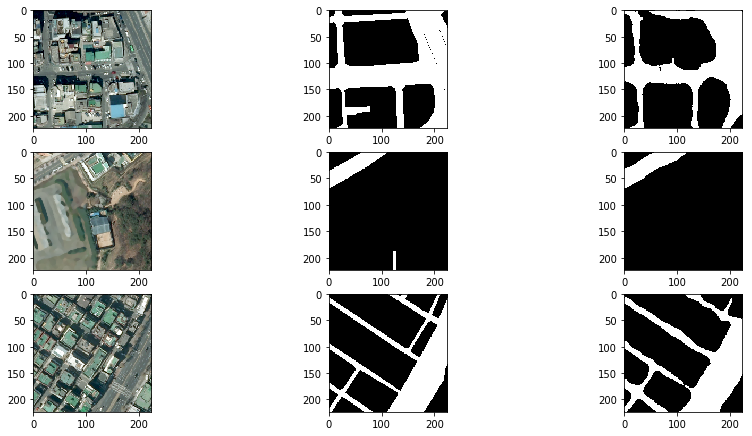

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as Funct
import sys
from collections import OrderedDict
import segData
from PIL import Image
from torchvision.transforms import ToPILImage
import torchvision.transforms as t
to_img = t.ToPILImage()
%matplotlib inline

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"

if __name__ == "__main__":
    import torch.optim as optim
    from torch.autograd import Variable
    from torch.utils.data import DataLoader
    import matplotlib.pyplot as plt
    import numpy as np
    
    
    def norm(x):
        return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))
    
    
    test_dataset = DataLoader(
        segData.DataS("val"),
        batch_size=4, shuffle=False, num_workers=4)    
    dataiter = iter(test_dataset)
    inputs, labels = dataiter.next()
    
    model = torch.load('Unet_2_model.pt')
    
    inputs = inputs.cuda()
    outputs = model(Variable(inputs))
    inputs = inputs.cpu().numpy()
    inputs = np.transpose(inputs,(0, 2, 3, 1))

    labels = labels.numpy()
    labels = np.transpose(labels,(0, 2, 3, 1))
    labels = 255 * labels

    outputs = (outputs.data).cpu().numpy()
    outputs = np.transpose(outputs,(0, 2, 3, 1))
    outputs = 255 * outputs
    
    fig = plt.figure(figsize=(15, 10))
    for i in range(3):
        plt.subplot(431 + 3 * i)
        plt.imshow(inputs[i], interpolation='nearest')        
        plt.subplot(432 + 3 * i)
        label = to_img(labels[i])   
        plt.imshow(label,interpolation='nearest', cmap = "gray")        
        plt.subplot(433 + 3 * i)
        output = to_img(outputs[i]) 
        plt.imshow(np.array(output)>125, interpolation='nearest', cmap = "gray")
    plt.show()